In [14]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
from model import *
from utils import *

import torch
import torch.optim

from skimage.measure import compare_psnr
from downsampler import Downsampler

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True
dtype = torch.cuda.FloatTensor

factor = 4 # 8
path_to_image = 'data/denoising/metro_aalto.jpg'
path_to_result_file = 'results/metro_aalto.jpg'

HR and LR resolutions: (672, 384), (168, 96)


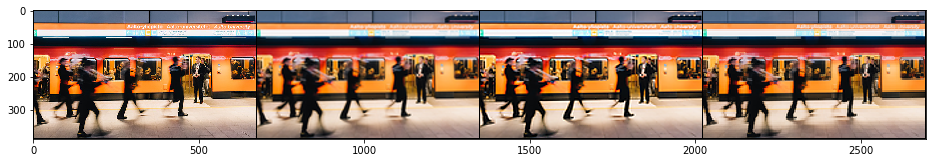

PSNR bicubic: 21.2583   PSNR nearest: 20.0483


In [2]:
imgs = load_LR_HR_imgs_sr(path_to_image, -1, factor, 'CROP')

imgs['bicubic_np'], imgs['sharp_np'], imgs['nearest_np'] = get_baselines(imgs['LR_pil'], imgs['HR_pil'])

plot_image_grid([imgs['HR_np'], imgs['bicubic_np'], imgs['sharp_np'], imgs['nearest_np']], 4,12);
print ('PSNR bicubic: %.4f   PSNR nearest: %.4f' %  (
                                    compare_psnr(imgs['HR_np'], imgs['bicubic_np']), 
                                    compare_psnr(imgs['HR_np'], imgs['nearest_np'])))

In [3]:
input_depth = 32
 
INPUT =     'noise'
pad   =     'reflection'

LR = 0.01

if factor == 4: 
    num_iter = 2000
    reg_noise_std = 0.03
elif factor == 8:
    num_iter = 4000
    reg_noise_std = 0.05
else:
    assert False, 'We did not experiment with other factors'

In [4]:
from torch.autograd import Variable

def fill_noise(x, noise_type):
    """Fills tensor `x` with noise of type `noise_type`."""
    if noise_type == 'u':
        x.uniform_()
    elif noise_type == 'n':
        x.normal_() 
    else:
        assert False

def get_noise(input_depth, method, spatial_size, noise_type='u', var=1./10):
    """Returns a pytorch.Variable of size (1 x `input_depth` x `spatial_size[0]` x `spatial_size[1]`) 
    initialized in a specific way.
    Args:
        input_depth: number of channels in the tensor
        method: `noise` for fillting tensor with noise; `meshgrid` for np.meshgrid
        spatial_size: spatial size of the tensor to initialize
        noise_type: 'u' for uniform; 'n' for normal
        var: a factor, a noise will be multiplicated by. Basically it is standard deviation scaler. 
    """
    if isinstance(spatial_size, int):
        spatial_size = (spatial_size, spatial_size)
    if method == 'noise':
        shape = [1, input_depth, spatial_size[0], spatial_size[1]]
        net_input = Variable(torch.zeros(shape))
        
        fill_noise(net_input.data, noise_type)
        net_input.data *= var            
    elif method == 'meshgrid': 
        assert input_depth == 2
        X, Y = np.meshgrid(np.arange(0, spatial_size[1])/float(spatial_size[1]-1), np.arange(0, spatial_size[0])/float(spatial_size[0]-1))
        meshgrid = np.concatenate([X[None,:], Y[None,:]])
        net_input=  Variable(torch.from_numpy(meshgrid)[None, :])
    else:
        assert False
        
    return net_input



In [5]:
net_input = get_noise(input_depth, INPUT, (imgs['HR_pil'].size[1], imgs['HR_pil'].size[0])).type(dtype).detach()
NET_TYPE = 'skip' # UNet, ResNet

net = create_model(downsample_channels = [128, 128, 128, 128, 128],
                    upsample_channels = [128, 128, 128, 128, 128],
                    skip_channels = [4, 4, 4, 4, 4],
                    input_channel_size = input_depth,
                    output_channel_size = 3,
                    upsample_mode='bilinear',
                    activation_function=nn.LeakyReLU(0.2, inplace=True),
                    padding_type=pad
                   ).type(dtype)

# Losses
mse = torch.nn.MSELoss().type(dtype)

img_LR_var = Variable(torch.from_numpy(imgs['LR_np'])[None, :]).type(dtype)

downsampler = Downsampler(n_planes=3, factor=factor, phase=0.5, preserve_size=True).type(dtype)

layer 0
layer 1
layer 2
layer 3
layer 4


In [6]:
def closure():
    global i
    
    if reg_noise_std > 0:
        net_input.data = net_input_saved + (noise.normal_() * reg_noise_std)
        
    out_HR = net(net_input)
    out_LR = downsampler(out_HR)

    total_loss = mse(out_LR, img_LR_var) 
    
    total_loss.backward()

    # Log
    psnr_LR = compare_psnr(imgs['LR_np'], var_to_np(out_LR))
    psnr_HR = compare_psnr(imgs['HR_np'], var_to_np(out_HR))
    print ('Iteration %05d    PSNR_LR %.3f   PSNR_HR %.3f' % (i, psnr_LR, psnr_HR), '\r', end='')
                      
    # History
    psnr_history.append([psnr_LR, psnr_HR])
    
    if i % 500 == 0:
        out_HR_np = var_to_np(out_HR)
        plot_image_grid([imgs['HR_np'], imgs['bicubic_np'], np.clip(out_HR_np, 0, 1)], factor=13, nrow=3)

    i += 1
    
    return total_loss

Starting optimization with ADAM


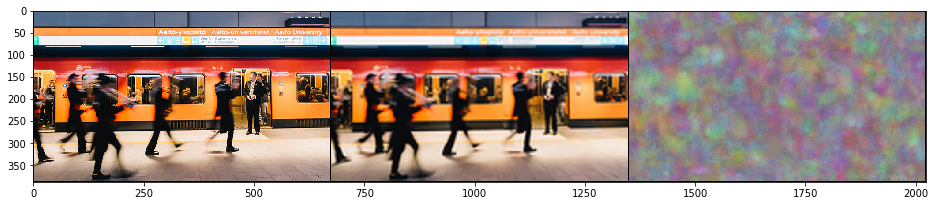

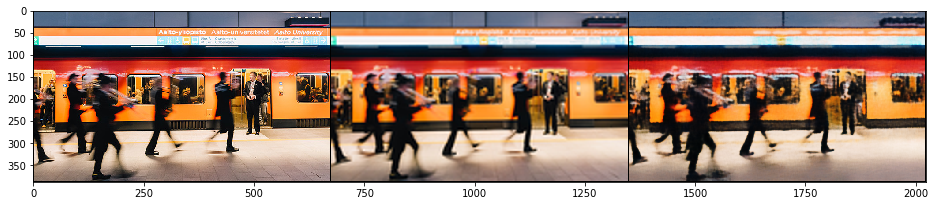

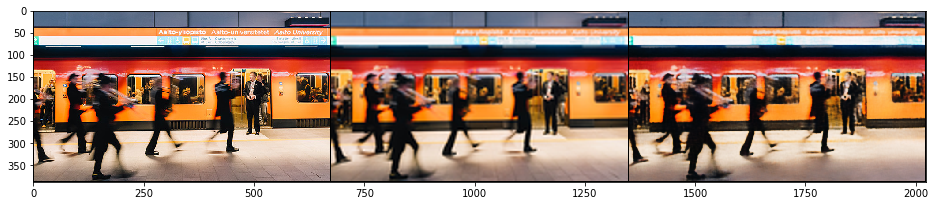

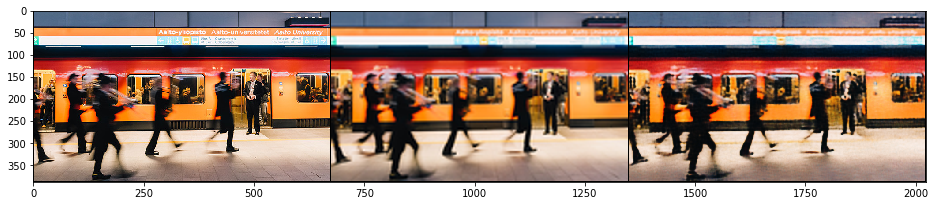

In [7]:
psnr_history = [] 
net_input_saved = net_input.data.clone()
noise = net_input.data.clone()

i = 0
print('Starting optimization with ADAM')
optimizer = torch.optim.Adam(net.parameters(), lr=LR)
        
for j in range(num_iter):
    optimizer.zero_grad()
    closure()
    optimizer.step()

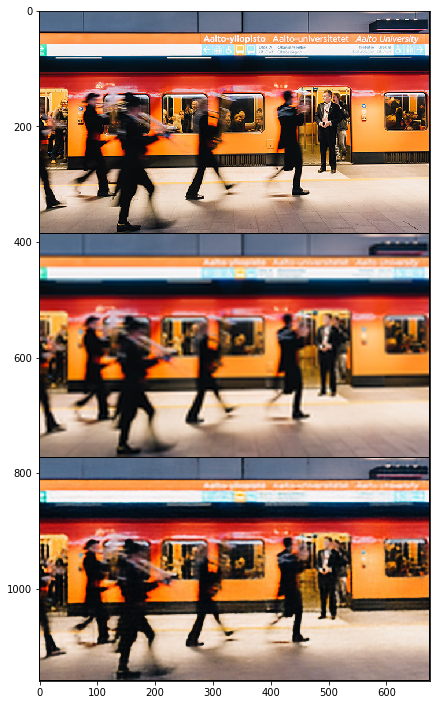

In [9]:
out_HR_np = np.clip(var_to_np(net(net_input)), 0, 1)
result_deep_prior = put_in_center(out_HR_np, imgs['orig_np'].shape[1:])

# For the paper we acually took `_bicubic.png` files from LapSRN viewer and used `result_deep_prior` as our result
plot_image_grid([imgs['HR_np'],
                 imgs['bicubic_np'],
                 out_HR_np], factor=4, nrow=1);

In [16]:
import scipy.misc
print(out_HR_np.shape)
scipy.misc.imsave(path_to_result_file, np.transpose(out_HR_np, (1, 2, 0)))


(3, 384, 672)
